<a href="https://colab.research.google.com/github/fahriyegrl/Malicious_Web-_Detection-_with-_1D_CNN/blob/main/Malicious_Web__Detection__with__1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
# Change the import statement to the correct location
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
!pip install tldextract -q

In [17]:
import tldextract

In [18]:
data = pd.read_csv('malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [19]:
val_size = 0.2
train_data, val_data = train_test_split(data, test_size=val_size, stratify=data['type'], random_state=0)
fig = go.Figure([go.Pie(labels=['Train Size', 'Validation Size'], values=[train_data.shape[0], val_data.shape[0]])])
fig.update_layout(title='Train and Validation Size')
fig.show()

In [20]:
fig = go.Figure([go.Pie(labels=['benign', 'defacement', 'malware', 'phishing'], values=data.type.value_counts())])
fig.update_layout(title='Percentage of Class (Benign, Defacement, Malware and Phishing)')
fig.show()

In [21]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    extracted = tldextract.extract(url) # Get the ExtractResult object
    subdomain = '<empty>' if extracted.subdomain == '' else extracted.subdomain # Access subdomain attribute
    domain = '<empty>' if extracted.domain == '' else extracted.domain # Access domain attribute
    domain_suffix = '<empty>' if extracted.suffix == '' else extracted.suffix # Access suffix attribute

    return [subdomain, domain, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])

    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)

    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')

    # scale log base 10
    data['values'] = np.log10(data['values'])

    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())

    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)

    return data

def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='label')
    fig.update_layout(title=title)
    fig.show()


In [22]:
data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [23]:
fig = go.Figure([go.Bar(
    x=['domain', 'Subdomain', 'Domain Suffix'],
    y = [data.domain.nunique(), data.subdomain.nunique(), data.domain_suffix.nunique()]
)])
fig.show()

In [24]:
data[(data['domain'] == 'google') & (data['type'] == 'phishing')].head()

,url,type,subdomain,domain,domain_suffix
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,docs,google,com
4551,https://spreadsheets.google.com/spreadsheet/fo...,phishing,spreadsheets,google,com
6249,https://spreadsheets.google.com/spreadsheet/em...,phishing,spreadsheets,google,com
18018,https://spreadsheets.google.com/spreadsheet/em...,phishing,spreadsheets,google,com
18116,https://sites.google.com/site/habbomoedasgt/,phishing,sites,google,com


In [25]:
###   do tokenization on the url so that it can be used as input to the CNN model
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
oreilly.com/catalog/9780596007072/

After tokenization: 
[3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]


In [26]:
### Each url has a different length, therefore padding is needed to equalize each url length

sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {train_seq[0]}')
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {train_seq[0]}')

Before padding: 
 [3, 11, 2, 7, 14, 14, 27, 12, 9, 3, 13, 6, 9, 5, 4, 5, 14, 3, 21, 6, 36, 38, 31, 24, 34, 36, 39, 24, 24, 38, 24, 38, 25, 6]
After padding: 
 [ 3 11  2  7 14 14 27 12  9  3 13  6  9  5  4  5 14  3 21  6 36 38 31 24
 34 36 39 24 24 38 24 38 25  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [27]:
###  encode subdomain, domain, suffix domains and label into numerical variables

unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}

    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1

    # count unique value
    unique_value[feature] = label_index['<unknown>']

    # encode
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]

train_data.head()

,url,type,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,phishing,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,benign,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,benign,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,benign,3,3,1
4,skate-works.com/oakland_university_?b=1,benign,0,4,0


In [28]:
### encode the target variable (label) to numeric
### 'benign', 'defacement', 'malware', 'phishing'


for data in [train_data, val_data]:
    data.loc[:, 'type'] = [0 if i == 'benign' else 1 if i=='defacement' else 2 if i=='malware' else 3 for i in data.loc[:, 'type']]

train_data.head()


,url,type,subdomain,domain,domain_suffix
0,oreilly.com/catalog/9780596007072/,3,0,0,0
1,content.usatoday.com/community/tags/topic.aspx...,0,1,1,0
2,e.pa.ypal.help.sec.us-login-cgi.bin.resolution...,0,2,2,0
3,news.stanford.edu/news/2006/february22/med-ill...,0,3,3,1
4,skate-works.com/oakland_university_?b=1,0,0,4,0


In [34]:
### Create CNN Model
def convolution_block(x):
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)

    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    conv_layer = layers.Flatten()(conv_layer)

    return conv_layer

def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)

    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value):
    input_layer = []

    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    print(sequence_input_layer.shape)
    input_layer.append(sequence_input_layer)

    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    print(char_embedding.shape)
    conv_layer = convolution_block(char_embedding)
    print(conv_layer.shape)

    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)

    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    print(fc_layer.shape)

    # dense layer
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    print(fc_layer.shape)

    # output layer
    output_layer = layers.Dense(4, activation='softmax')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

    # # output layer
    # output_layer = layers.Dense(4, activation='softmax')(fc_layer)   ## softmax
    # print(output_layer.shape)
    # model = models.Model(inputs=input_layer, outputs=output_layer)
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])  ## 'sparse_categorical_crossentropy'
    # return model


(None, 234)
(None, 234, 32)
(None, 37440)
(None, 37452)
(None, 37452)
(None, 128)
(None, 128)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



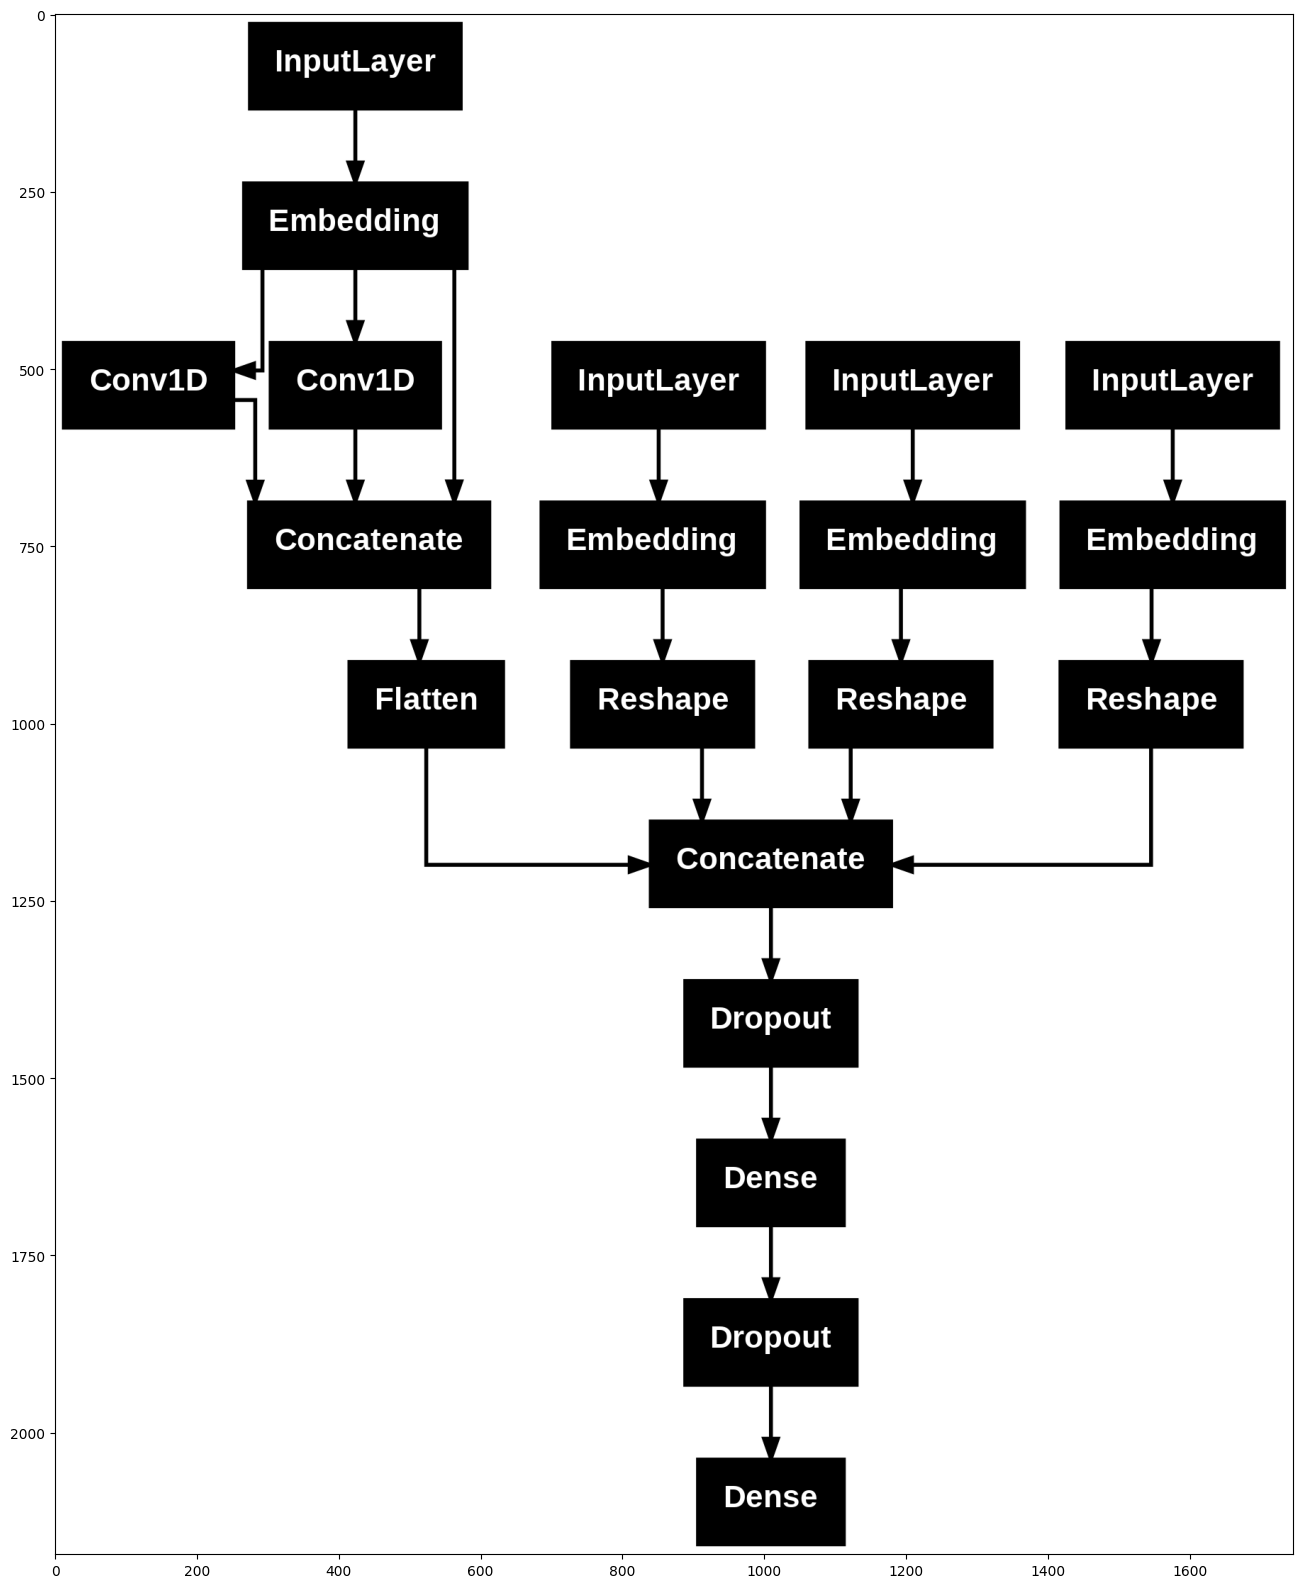

In [35]:
model = create_model(sequence_length, n_char, unique_value)

# show model architecture
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(20, 20))
plt.imshow(model_image)
plt.show()

In [36]:
### The model received 4 inputs, the first input came from URL that has been done tokenization and padding.
### Other inputs are subdomains, domains and suffix domains that have been encoded.
### URL input will pass through embedding layer and convolution layer while other input will pass embedding layer.
###Then the results from each input will be concatenated.

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ url_input (InputLayer)    │ (None, 234)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 234, 32)        │         10,656 │ url_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 234, 64)        │          6,208 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 234, 64)        │         10,304 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subdomain_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ domain_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ domain_suffix_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 234, 160)       │              0 │ embedding_4[0][0],     │
│ (Concatenate)             │                        │                │ conv1d_2[0][0],        │
│                           │                        │                │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 4)           │        143,028 │ subdomain_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 4)           │        516,652 │ domain_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 4)           │          3,320 │ domain_suffix_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 37440)          │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 4)              │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 4)              │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 4)              │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 37452)          │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ reshape_3[0][0],       │
│                           │                        │                │ reshape_4[0][0],       │
│                           │                        │                │ reshape_5[0][0]        │
├──────────────────────

 Total params: 5,484,668 (20.92 MB)

 Trainable params: 5,484,668 (20.92 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
### Model Training

# create train data

#train_x = [train_seq.astype('float32'), train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]

train_x = [
    train_seq.astype('float32'),
    tf.convert_to_tensor(np.asarray(train_data['subdomain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain_suffix'], dtype='int32').reshape(-1, 1))
]
train_y = train_data['type'].astype(int).values
train_y[:1]



early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_split=0.2, shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9176 - loss: 0.2363 - val_accuracy: 0.9681 - val_loss: 0.0995
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



6512/6512 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9659 - loss: 0.1035 - val_accuracy: 0.9737 - val_loss: 0.0818
Epoch 3/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9735 - loss: 0.0820 - val_accuracy: 0.9756 - val_loss: 0.0779
Epoch 4/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9779 - loss: 0.0675 - val_accuracy: 0.9765 - val_loss: 0.0760
Epoch 5/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9807 - loss: 0.0586 - val_accuracy: 0.9775 - val_loss: 0.0744
Epoch 6/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9828 - loss: 0.0526 - val_accuracy: 0.9771 - val_loss: 0.0794
Epoch 7/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9843 - loss: 0.0474 - val_accuracy: 0.9771 - val_loss: 0.0780
Epoch 8/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9860 - loss: 0.0432 - val_accuracy: 0.9770 - val_loss: 0.0772
Epoch 9/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9869 - loss: 0.0406 - val

In [42]:
val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y = val_data['type'].values

In [43]:
val_x[0].shape

(130239, 234)

In [44]:
val_x[0]

array([[18,  4,  4, ...,  0,  0,  0],
       [ 4, 11, 20, ...,  0,  0,  0],
       [15,  5, 27, ...,  0,  0,  0],
       ...,
       [13,  5, 11, ...,  0,  0,  0],
       [ 5, 33,  2, ...,  0,  0,  0],
       [18,  4,  4, ...,  0,  0,  0]], dtype=int32)

In [46]:

import tensorflow as tf
import numpy as np

val_x = [
    val_seq,
    tf.convert_to_tensor(np.asarray(val_data['subdomain'], dtype='int32').reshape(-1, 1)), # Convert to tensor
    tf.convert_to_tensor(np.asarray(val_data['domain'], dtype='int32').reshape(-1, 1)),    # Convert to tensor
    tf.convert_to_tensor(np.asarray(val_data['domain_suffix'], dtype='int32').reshape(-1, 1)) # Convert to tensor
]
val_y = val_data['type'].values


In [50]:
val_pred = model.predict(val_x)

print(f'Validation Data:\n{val_data.type.value_counts()}')


4070/4070 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Validation Data:
type
0    85621
1    19292
3    18822
2     6504
Name: count, dtype: int64


In [54]:
y_pred_classes = val_pred.argmax(axis=1)
print("Unique values in y_true:", np.unique(val_y))
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))


Unique values in y_true: [0 1 2 3]
Unique values in y_pred_classes: [0 1 2 3]


In [55]:
print("Shape of y_true:", val_y.shape)
print("Shape of y_pred_classes:", y_pred_classes.shape)


Shape of y_true: (130239,)
Shape of y_pred_classes: (130239,)


In [57]:
val_y = val_y.astype(int)
y_pred_classes = y_pred_classes.astype(int)


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Precision, Recall, and F1 for each class
precision = precision_score(val_y, y_pred_classes, average='weighted')
recall = recall_score(val_y, y_pred_classes, average='weighted')
f1 = f1_score(val_y, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9779086178221021
Recall: 0.9780250155483381
F1-score: 0.9779458952456931


In [61]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(val_y, y_pred_classes)

# Print accuracy
print("Accuracy Score:", accuracy)


Accuracy Score: 0.9780250155483381
